In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shap

from pathlib import Path
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

import lightgbm as lgb

# from context import wfm
import wfm

shap.initjs()

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
root_path = Path().resolve().parent
input_path = root_path / "data" / "input"
images_path = root_path / "images"
output_path = root_path / "output"

input_data = wfm.preprocessing.get_input_data(input_path)
input_data.head()

,wildfire,id,año,material,npisos,h_viv,n_daño,orientacio,elevación,pendiente,...,fact_agua,n_conjman,d_conj_man,n_conj10m,d_conj_10m,n_conj20m,d_conj_20m,cord_x,cord_y,geometry
0,Limache,0,1978.0,Sólido,1.0,2.5,Ninguno,E,67.4828,11.326300,...,No,6,10.0000,13,10.0000,4,20.0000,291295.0,6347530.0,"POLYGON ((291288.520 6347524.396, 291294.786 6..."
1,Limache,0,2004.0,Liviano,1.0,2.5,Ninguno,E,67.9629,10.550100,...,No,6,10.0000,13,10.0000,4,20.0000,291301.0,6347550.0,"POLYGON ((291298.638 6347547.595, 291299.696 6..."
2,Limache,0,2009.0,Liviano,1.0,2.5,Ninguno,E,64.9530,10.819000,...,No,6,10.0000,13,10.0000,4,20.0000,291300.0,6347520.0,"POLYGON ((291298.469 6347519.147, 291300.967 6..."
3,Limache,0,1978.0,Liviano,1.0,2.5,Ninguno,E,61.4631,0.953306,...,No,6,10.0000,12,10.0000,4,20.0000,291334.0,6347500.0,"POLYGON ((291329.666 6347502.326, 291340.503 6..."
4,Limache,0,1978.0,Sólido,1.0,2.5,Ninguno,E,61.5823,0.693135,...,No,6,23.5041,12,23.5041,4,37.6067,291371.0,6347510.0,"POLYGON ((291363.407 6347527.937, 291365.271 6..."


In [3]:
def get_cat_dict(df, col):
    return dict(zip(df[col], df[col].cat.codes))

In [4]:
# --- Display Data --- 
split_random_state = 42
X_display = (
    input_data.drop(columns=["wildfire", "id", "n_daño", "geometry"])
    .pipe(lambda x: pd.DataFrame(x))
)
y_display = input_data["n_daño"].astype("category")

# --- Data for Algorithm ---
X = X_display.copy()
cat_codes = {col: X_display.pipe(get_cat_dict, col=col) for col in X_display.select_dtypes("category")}
for col, d in cat_codes.items():
    X.loc[:, col] = X[col].map(d)
y = y_display.cat.codes

# --- Split Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=split_random_state
)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"{y_train.size} train records and {y_test.size} test records.")

X shape: (2694, 27)
y shape: (2694,)
1885 train records and 809 test records.


In [5]:
# --- lGBM Structure ---
train_data =lgb.Dataset(X_train, label=y_train,)
test_data = lgb.Dataset(X_test, label=y_test)

In [6]:
params = {
#     "max_bin": 512,
    "learning_rate": 0.05,
#     "boosting_type": "gbdt",
#     "objective": "binary",
#     "metric": "binary_logloss",
    'objective': 'multiclass',
    'num_class':3,
    'metric': 'multi_logloss',
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
#     "boost_from_average": True
}

num_round = 1000

model = lgb.train(
    params,
    train_data,
    num_round,
    valid_sets=[test_data],
#     early_stopping_rounds=50,
    verbose_eval=1000
)

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[1000]	valid_0's multi_logloss: 1.49766e-06


In [8]:
y_pred = np.argmax(model.predict(X_test), axis=1)

In [9]:
print(
    classification_report(
        y_test,
        y_pred,
    )
)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       727
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00        74

    accuracy                           1.00       809
   macro avg       1.00      1.00      1.00       809
weighted avg       1.00      1.00      1.00       809



In [11]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

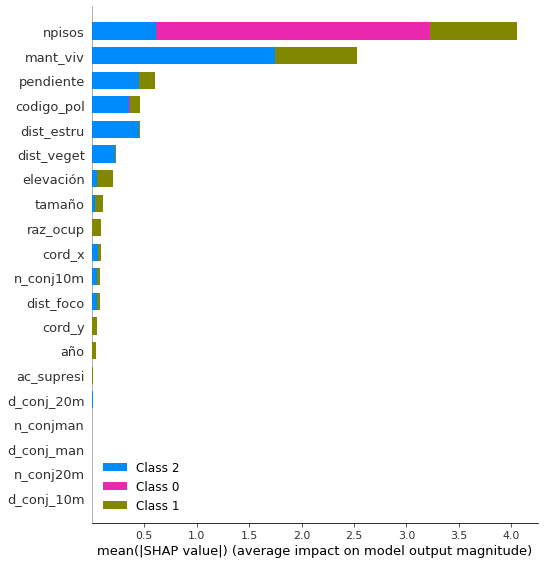

In [12]:
shap.summary_plot(shap_values, X, show=False)

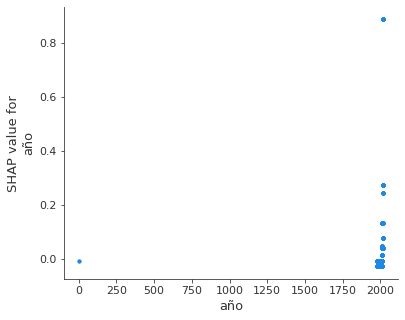

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


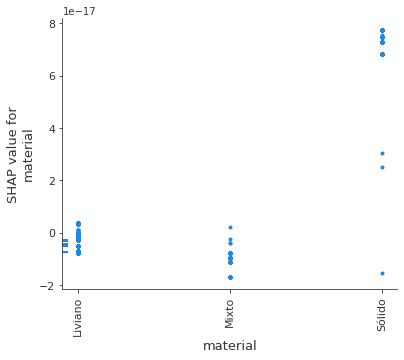

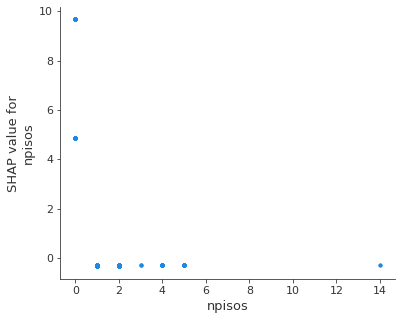

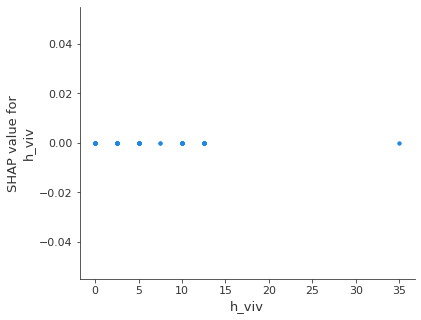

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


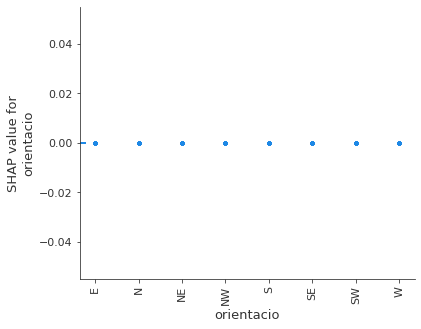

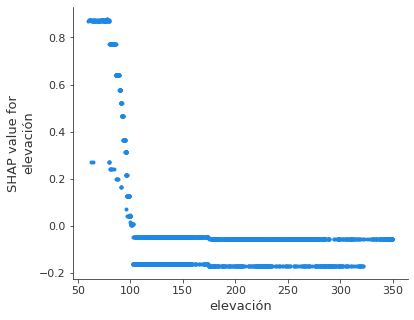

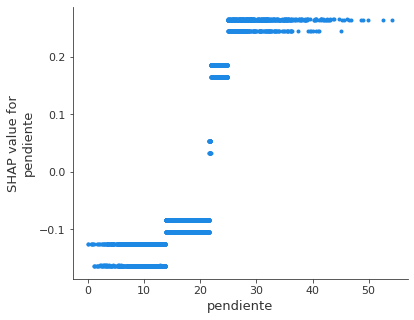

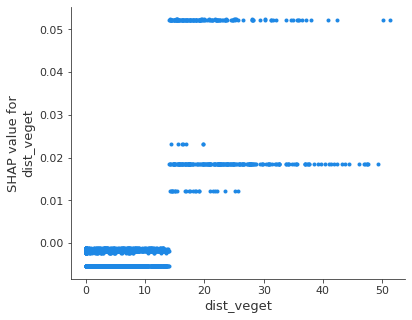

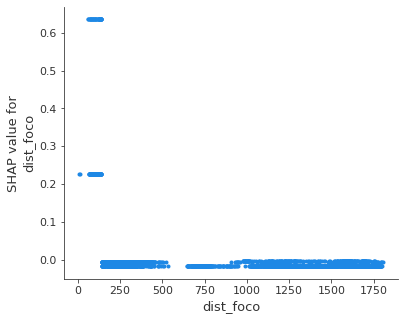

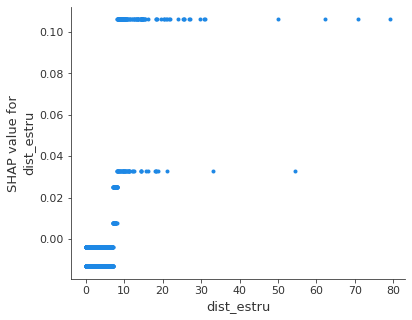

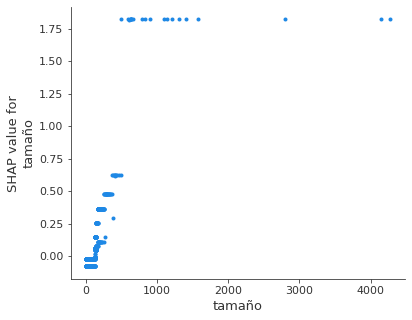

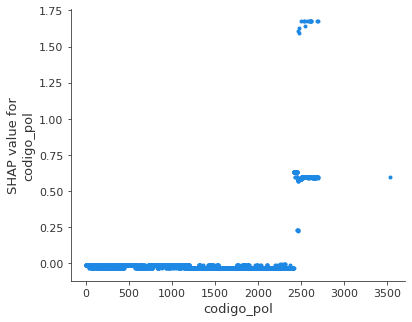

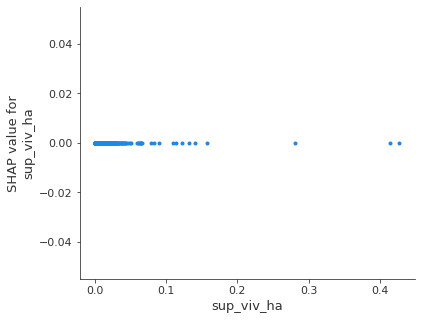

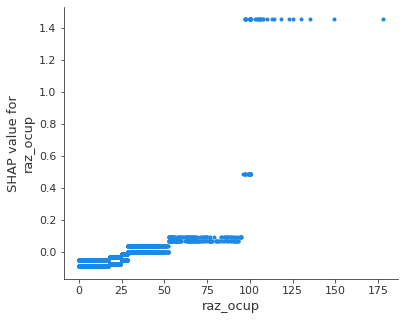

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


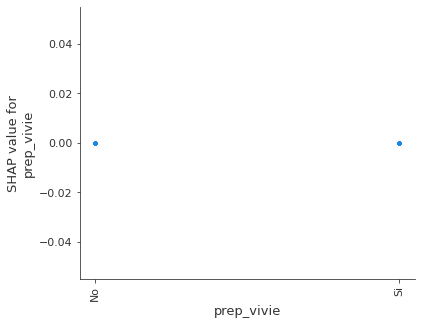

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


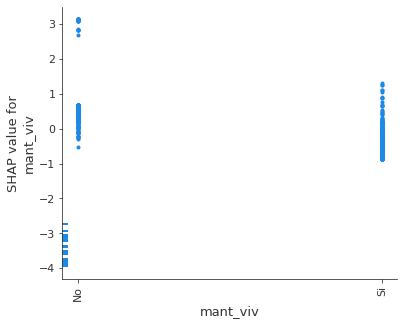

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


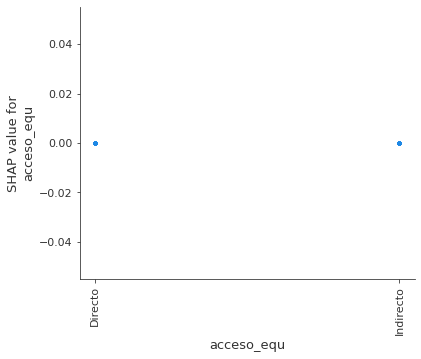

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


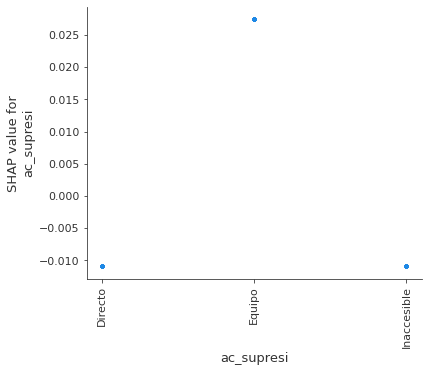

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


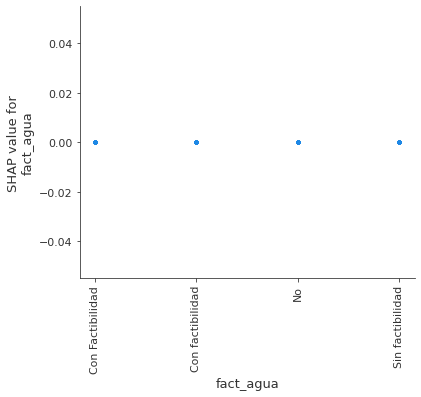

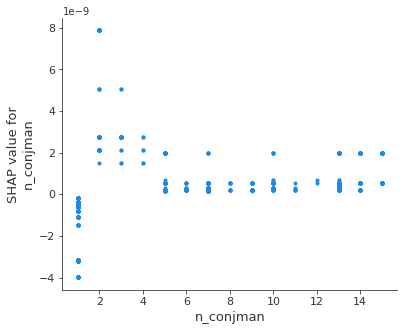

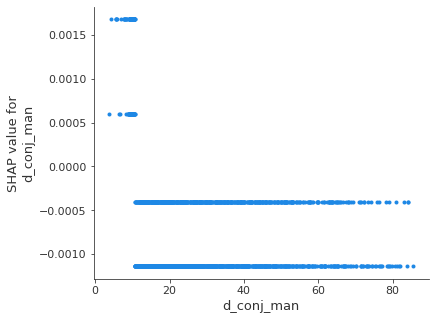

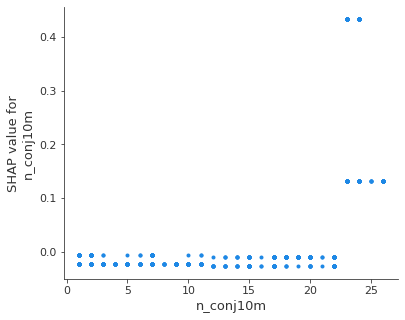

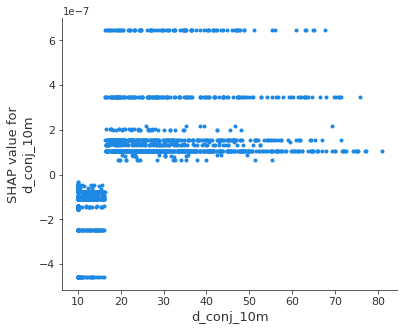

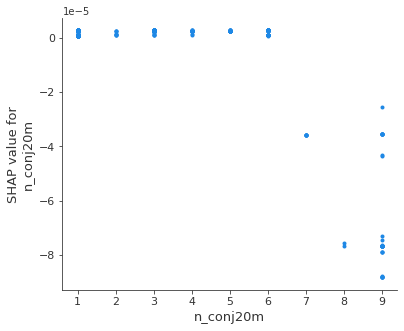

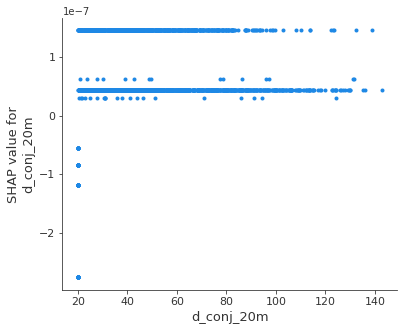

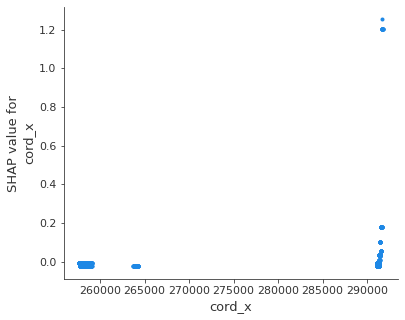

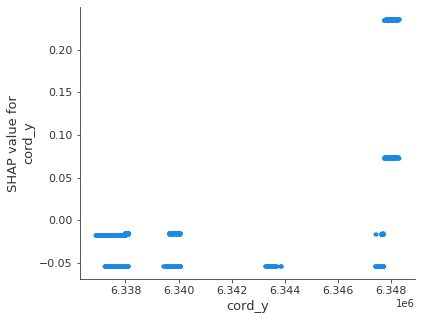

In [14]:
for name in X_train.columns:
    shap.dependence_plot(
        name,
        shap_values[1],
        X,
        display_features=X_display,
        interaction_index=None
    )